In [1]:
import hdffiles as hd

In [2]:
hd

<module 'hdffiles' from '/workspace/zhaoty/GWToolkit/notebooks/hdffiles.py'>

In [2]:
import readligo as rl
from pycbc.types.timeseries import TimeSeries
from lal import LIGOTimeGPS
from pycbc.psd import interpolate
import numpy as np
import matplotlib.pyplot as plt
from utils import Data_utils,Glitch_Generator
from astropy import constants as const
import hdffiles as hd
from tqdm import tqdm

class PSD_Sampler(object):
    def __init__(self,datadir='/workspace/zhaoty/O1_data/',random_seed=42,noise_interval = 4096,target_sampling_rate = 4096):
        self.datadir = datadir
        self.random_seed = random_seed
        self.filelist =  rl.FileList(directory=self.datadir) 
        self.noise_timeline = hd.NoiseTimeline(background_data_directory= self.datadir,
                                            random_seed=self.random_seed)
        self.noise_interval = noise_interval
        self.dq_bits=(0, 1, 2, 3)
        self.inj_bits=(0, 1, 2, 4)

        self.original_sampling_rate = 16384
        self.target_sampling_rate = target_sampling_rate
        self.PSDs = None
    
    def gps_time_sampler(self,):

        delta_t = int(self.noise_interval/2)
        '''
    half of Width of the background noise interval (in seconds) around the event_time,
    ; which is used to make the injection. Should be larger than (see below):
    ;   sample_length = seconds_before_event + seconds_after_event
    ; because we need to crop off the edges that are corrupted by the whitening.
        '''
        #sample is interval middle point
        noise_times = self.noise_timeline.sample(delta_t=delta_t,dq_bits=self.dq_bits,inj_bits=self.inj_bits,return_paths=False)
        start = noise_times - delta_t
        return start

    def generate_psd(self,start,ifo = 'H1',signal_length = 8):
        
        sampling_factor = int(self.original_sampling_rate / self.target_sampling_rate)
        stop = start + self.noise_interval
        
        strain, time, dqmask, injmask = rl.getstrain_cvmfs(start, stop, ifo, self.filelist)

        strain = strain[::sampling_factor]

        timeseries = TimeSeries(initial_array=strain,
                                delta_t=1.0/self.target_sampling_rate,
                                epoch=LIGOTimeGPS(start))
        psd = timeseries.psd(4)
        psd = interpolate(psd, delta_f = 1 / signal_length)
        return psd

    def generate_psds(self,num,ifo = 'H1',signal_length = 8):
        psds = np.zeros([num,int(self.target_sampling_rate/2*signal_length+1)])
        
        for i in tqdm(range(num)):
            start = psd_sampler.gps_time_sampler()
            psd = psd_sampler.generate_psd(start,ifo = ifo,signal_length = signal_length)
            psds[i,:] = np.sqrt(psd.data)

        self.PSDs = psds
        print('Generate {} PSDs from real LIGO noise done !!!'.format(num))

In [3]:
psd_sampler = PSD_Sampler(datadir='/workspace/zhaoty/O1_H1_all/')

Using data directory /workspace/zhaoty/O1_H1_all/ ...


In [4]:
print(psd_sampler.noise_timeline.gps_start_time,psd_sampler.noise_timeline.gps_end_time)

1126072320 1137254400


In [5]:
len(psd_sampler.noise_timeline.hdf_files)

1847

In [32]:
psd_sampler = PSD_Sampler()
#start = psd_sampler.gps_time_sampler()
#psd = psd_sampler.generate_psd(start)
psd_sampler.generate_psds(10)




Using data directory /workspace/zhaoty/O1_data/ ...


100%|██████████| 10/10 [06:20<00:00, 38.05s/it]

Generate 10 PSDs from real LIGO noise done !!!


In [6]:
psd_sampler.gps_time_sampler()

1132267520

In [11]:
def generate_psd(start,ifo = 'H1',noise_interval = 4096,signal_length = 8):
    original_sampling_rate = 16384
    target_sampling_rate = 4096
    sampling_factor = int(original_sampling_rate / target_sampling_rate)
    stop = start + noise_interval
    
    strain, time, dqmask, injmask = rl.getstrain_cvmfs(start, stop, ifo, filelist)

    strain = strain[::sampling_factor]

    timeseries = TimeSeries(initial_array=strain,
                            delta_t=1.0/target_sampling_rate,
                            epoch=LIGOTimeGPS(start))
    psd = timeseries.psd(4)
    psd = interpolate(psd, delta_f = 1 / signal_length)
    return psd

In [12]:
psd = generate_psd(start,stop)

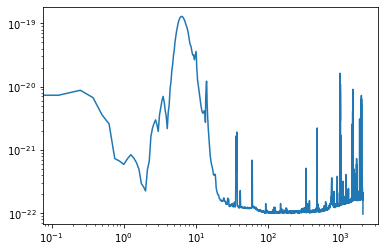

In [13]:

plt.loglog(psd.sample_frequencies,np.sqrt(psd.data))

In [11]:
from astropy import constants as const
from scipy import constants as C

In [3]:
M_sun = float(const.M_sun.base)
m1_range = [1.4*M_sun,30.0*M_sun]
type(1.4*M_sun)

float

In [7]:
Glitch_gen = Glitch_Generator(sampling_rate=target_sampling_rate,time_duration=signal_length)

In [27]:
types = ['Gaussian','SG','RD','SL']
for type in types:
    print(type)
    a = Glitch_gen.generate_glitchs( 1,type=type)


Gaussian
SG
RD
SL
36.45738794954764 0.5


In [17]:
Glitch_gen.liner_random(1,2)

1.563762213211569

In [18]:
m_1 = 2.0 * float(const.M_sun.base)
m_2 = 3.5 * float(const.M_sun.base)
m_c = (m_1 * m_2)**(3/5) / (m_1 + m_2)**(1/5)
tau = Glitch_gen.sample_times - 6.0
print((5 * C.G * m_c / C.c**3)**(-5/8)* tau**(5/8))

[      nan       nan       nan ... 698.29785 698.35114 698.4044 ]


/tmp/ipykernel_75670/2051538394.py:5: RuntimeWarning: invalid value encountered in power
  print((5 * C.G * m_c / C.c**3)**(-5/8)* tau**(5/8))


In [25]:
print(tau[:10],tau[:10]**(5/8))

[-6.        -5.999756  -5.9995117 -5.9992676 -5.9990234 -5.9987793
 -5.998535  -5.998291  -5.998047  -5.9978027] [nan nan nan nan nan nan nan nan nan nan]


/tmp/ipykernel_75670/3032046924.py:1: RuntimeWarning: invalid value encountered in power
  print(tau[:10],tau[:10]**(5/8))


In [19]:
a[0]

-0.0

In [18]:
t0 = Glitch_gen.liner_random(Glitch_gen.t0_range[0],Glitch_gen.t0_range[1])

In [26]:
(-6)**(5/8)

(-1.172692620049643+2.8311304278186875j)

In [3]:
q = noise_timeline._get_hdf_files() 

In [4]:
q

[{'file_path': '/workspace/zhaoty/O1_data/H-H1_LOSC_16_V1-1126072320-4096.hdf5',
  'start_time': 1126072320,
  'detector': 'H1',
  'duration': 4096,
  'inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
  'dq_mask': array([  0,   0,   0, ..., 127, 127, 127], dtype=int32)},
 {'file_path': '/workspace/zhaoty/O1_data/H-H1_LOSC_16_V1-1126076416-4096.hdf5',
  'start_time': 1126076416,
  'detector': 'H1',
  'duration': 4096,
  'inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
  'dq_mask': array([127, 127, 127, ..., 127, 127, 127], dtype=int32)},
 {'file_path': '/workspace/zhaoty/O1_data/H-H1_LOSC_16_V1-1126080512-4096.hdf5',
  'start_time': 1126080512,
  'detector': 'H1',
  'duration': 4096,
  'inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
  'dq_mask': array([127, 127, 127, ..., 127, 127, 127], dtype=int32)},
 {'file_path': '/workspace/zhaoty/O1_data/H-H1_LOSC_16_V1-1126084608-4096.hdf5',
  'start_time': 1126084608,
  'detector': 'H1',
  'duration': 40

In [5]:
noise_timeline.gps_start_time

1126072320

In [8]:
q[1]
#.split('/')[-1].split('_')[0].split('-')[-1]

{'file_path': '/workspace/zhaoty/O1_data/H-H1_LOSC_16_V1-1126076416-4096.hdf5',
 'start_time': 1126076416,
 'detector': 'H1',
 'duration': 4096,
 'inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
 'dq_mask': array([127, 127, 127, ..., 127, 127, 127], dtype=int32)}

In [11]:
dq_bits=(0, 1, 2, 3)
inj_bits=(0, 1, 2, 4)
delta_t = 16
gps_time = noise_timeline.rng.randint(noise_timeline.gps_start_time + delta_t,
                                        noise_timeline.gps_end_time - delta_t)
print(gps_time)
            # If it is a valid time, return it
if noise_timeline.is_valid(gps_time=gps_time, delta_t=delta_t,
                             dq_bits=dq_bits, inj_bits=inj_bits):
    print(gps_time,'is valid')
print('Done')

1126110494
1126110494 is valid
Done


In [13]:
noise_timeline.sample(delta_t=16)

1126078601

In [11]:
noise_timeline.gps_start_time

1126072320

In [4]:
noise_times = noise_timeline.sample(delta_t = 4,dq_bits=dq_bits,inj_bits=inj_bits)

In [7]:
noise_times = noise_timeline.sample(delta_t=2048.0,dq_bits=dq_bits,inj_bits=inj_bits)

TypeError: slice indices must be integers or None or have an __index__ method

In [25]:
np.zeros([100,20.0])

TypeError: 'float' object cannot be interpreted as an integer

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from gwtoolkit.gw.readligo import FileList, getstrain_cvmfs
from gwtoolkit.gw.gwosc_cvmfs import GWOSC

In [79]:
class Glitch_Sampler(GWOSC):
    def __init__(self, glitch_dir = '../tests/gw/trainingset_v1d1_metadata.csv', signal_length=8):
        super().__init__(ifo='H1', data_dir='/workspace/zhaoty/dataset/O1_H1_All/',
                         sampling_frequency=4096, noise_interval=1024,
                 dq_bits=(0, 1, 2, 3), inj_bits=(0, 1, 2, 4))
        self.glitch_meta_data = pd.read_csv(glitch_dir)
        self.peak_time = self.glitch_meta_data.peak_time.astype('float64') + self.glitch_meta_data.peak_time_ns.astype('float64') * 1e-9
        self.start_time = self.glitch_meta_data.start_time.astype('float64') + self.glitch_meta_data.start_time_ns.astype('float64') * 1e-9
        self.duration = self.glitch_meta_data.duration
        self.signal_length = signal_length
    
    def get_start_time(self):
        idx = np.random.randint(0,high=len(self.glitch_meta_data))
        if self.duration[idx] > self.signal_length:
            return int(self.start_time[idx] - np.random.rand(1) * (self.duration[idx] - self.signal_length +0.5))
        else:
            return int(self.start_time[idx] + np.random.rand(1) * (self.signal_length - self.duration[idx] +0.5))
    
    def get_strain(self,):
        strain = None
        while strain is None:
            try:
                start_time = self.get_start_time()
                strain, time = getstrain_cvmfs(start_time, start_time+self.signal_length,
                                                 self.ifo, self.filelist, inj_dq_cache=0)
            except:
                pass
        sampling_factor = int(self.original_sampling_rate / self.sampling_frequency)
        strain = strain[::sampling_factor]
        return strain
        

In [80]:
glitch_sampler = Glitch_Sampler()
glitch_meta_data = glitch_sampler.glitch_meta_data

Using data directory /workspace/zhaoty/dataset/O1_H1_All/ ...


In [81]:
#glitch_sampler.get_start_time()
glitch_sampler.ifo



'H1'

In [42]:
filelist = FileList(directory='/workspace/zhaoty/dataset/O1_H1_All/')

Using data directory /workspace/zhaoty/dataset/O1_H1_All/ ...


In [70]:
start_time = glitch_sampler.get_start_time()
strain, time = getstrain_cvmfs(1132666173, 1132666173+glitch_sampler.signal_length,
                                                 glitch_sampler.ifo, glitch_sampler.filelist, inj_dq_cache=0)

In [75]:
strain.shape

(131072,)

In [76]:
glitch_sampler.get_start_time()

1131526736

In [83]:
glitch_sampler.get_strain().shape

(131072,)

In [66]:
131072/4096

32.0

In [68]:
glitch_sampler.signal_length

8

In [15]:
glitch_meta_data.keys()

Index(['event_time', 'ifo', 'peak_time', 'peak_time_ns', 'start_time',
       'start_time_ns', 'duration', 'search', 'process_id', 'event_id',
       'peak_frequency', 'central_freq', 'bandwidth', 'channel', 'amplitude',
       'snr', 'confidence', 'chisq', 'chisq_dof', 'param_one_name',
       'param_one_value', 'gravityspy_id', 'label', 'sample_type', 'url1',
       'url2', 'url3', 'url4'],
      dtype='object')

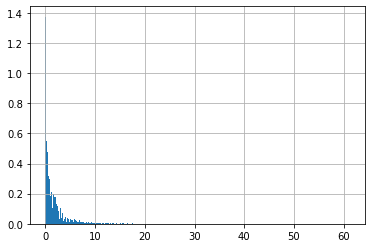

In [5]:
hist = glitch_meta_data.duration.hist(bins='auto', density=True)

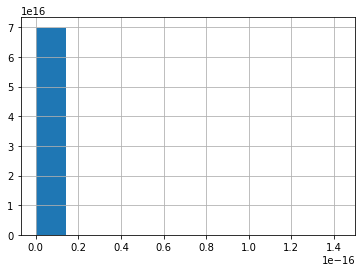

In [7]:
hist2 = glitch_meta_data.amplitude.hist( density=True)

In [19]:
glitch_meta_data.peak_time_ns

0       931639909
1       558593034
2       976317882
3       365233898
4       197264909
          ...    
7961    710937023
7962    324218034
7963    433593034
7964    496093034
7965    306639909
Name: peak_time_ns, Length: 7966, dtype: int64

In [23]:
type(glitch_peak_time)

pandas.core.series.Series

0       0.18750
1       0.94238
2       0.04688
3       0.82422
4       2.00366
         ...   
7961    9.00391
7962    0.03906
7963    1.16675
7964    0.10156
7965    4.09375
Name: duration, Length: 7966, dtype: float64